# 작사가 인공지능 만들기

## 1) 데이터 다운로드

In [12]:
# $ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/song_lyrics.zip
# $ unzip song_lyrics.zip -d ~/aiffel/lyricist/data/lyrics

## 2) 데이터 읽어오기

In [13]:
import glob
import os
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
import matplotlib.pyplot as plt

In [14]:
txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['How does a bastard, orphan, son of a whore', 'And a Scotsman, dropped in the middle of a forgotten spot in the Caribbean by providence impoverished,', 'In squalor, grow up to be a hero and a scholar? The ten-dollar founding father without a father']


## 3) 데이터 정제

### 특수문자 제거 함수

In [15]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)        
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)
    sentence = sentence.strip()
    sentence = '<start> ' + sentence + ' <end>'  
    
    return sentence

print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


### 정제 데이터 구축

In [16]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
        
    corpus.append(preprocess_sentence(sentence))
        
corpus[:10]    # 특수문자가 제거 되었는지 확인

['<start> how does a bastard , orphan , son of a whore <end>',
 '<start> and a scotsman , dropped in the middle of a forgotten spot in the caribbean by providence impoverished , <end>',
 '<start> in squalor , grow up to be a hero and a scholar ? the ten dollar founding father without a father <end>',
 '<start> got a lot farther by working a lot harder <end>',
 '<start> by being a lot smarter by being a self starter <end>',
 '<start> by fourteen , they placed him in charge of a trading charter and every day while slaves were being slaughtered and carted away <end>',
 '<start> across the waves , he struggled and kept his guard up <end>',
 '<start> inside , he was longing for something to be a part of <end>',
 '<start> the brother was ready to beg , steal , borrow , or barter then a hurricane came , and devastation reigned <end>',
 '<start> our man saw his future drip , dripping down the drain <end>']

### 토큰화 함수

In [17]:
def tokenize(corpus):

    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000,
        filters=' ',    # 별도로 전처리 로직을 추가할 수 있음
        oov_token="<unk>")  # out-of-vocabulary, 사전에 없었던 단어는 어떤 토큰으로 대체할지
    
    tokenizer.fit_on_texts(corpus) 
    
    tensor = tokenizer.texts_to_sequences(corpus)
    
    total_data_text = list(tensor)
    num_tokens = [len(tokens) for tokens in total_data_text]
    max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
    maxlen = int(max_tokens)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=maxlen)  

    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   78  626 ...    0    0    0]
 [   8    9    1 ...    1    4    3]
 [   4  831   29 ...    9  635    3]
 ...
 [   4  838 3383 ... 3383  348    3]
 [   2 6041   29 ...    0    0    0]
 [   2    8   42 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fd484dd7090>


In [18]:
for idx in tokenizer.index_word:    # 구축이 잘 됐는지 확인
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


## 4) 평가 데이터셋 분리

### 데이터셋 객체 생성

In [26]:
from sklearn.model_selection import train_test_split

src_input = tensor[:, :-1]
tgt_input = tensor[:, 1:]

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.3,
                                                          shuffle=True, 
                                                          random_state=34)

print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (123024, 19)
Target Train: (123024, 19)


In [37]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1    # <pad>추가

dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val)).shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

dataset, val_dataset

(<BatchDataset shapes: ((256, 19), (256, 19)), types: (tf.int32, tf.int32)>,
 <BatchDataset shapes: ((256, 19), (256, 19)), types: (tf.int32, tf.int32)>)

## 05) 인공지능 만들기

### 모델 생성 클래스

In [38]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = Embedding(vocab_size, embedding_size)
        self.rnn_1 = LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = LSTM(hidden_size, return_sequences=True)
        self.linear = Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

### history 그래프 생성 함수

In [39]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

### 모델 학습

In [40]:
optimizer = tf.keras.optimizers.Adam()

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none')

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

history = model.fit(dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    verbose=1)

Epoch 1/10
480/480 [==============================] - 75s 157ms/step - loss: 2.8735 - accuracy: 0.5664 - val_loss: 2.5456 - val_accuracy: 0.5923
Epoch 2/10
480/480 [==============================] - 76s 159ms/step - loss: 2.4498 - accuracy: 0.5999 - val_loss: 2.3902 - val_accuracy: 0.6056
Epoch 3/10
480/480 [==============================] - 78s 162ms/step - loss: 2.3191 - accuracy: 0.6104 - val_loss: 2.2934 - val_accuracy: 0.6134
Epoch 4/10
480/480 [==============================] - 77s 161ms/step - loss: 2.2234 - accuracy: 0.6172 - val_loss: 2.2261 - val_accuracy: 0.6192
Epoch 5/10
480/480 [==============================] - 78s 162ms/step - loss: 2.1399 - accuracy: 0.6238 - val_loss: 2.1714 - val_accuracy: 0.6244
Epoch 6/10
480/480 [==============================] - 79s 164ms/step - loss: 2.0677 - accuracy: 0.6297 - val_loss: 2.1280 - val_accuracy: 0.6293
Epoch 7/10
480/480 [==============================] - 78s 163ms/step - loss: 2.0016 - accuracy: 0.6356 - val_loss: 2.0909 - val_ac

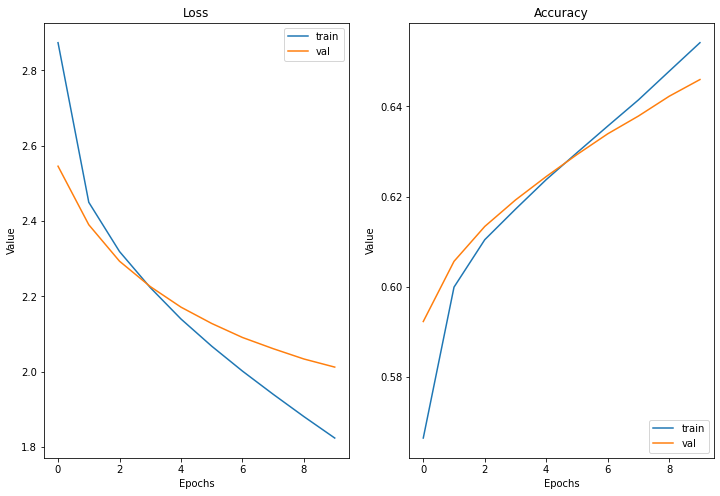

In [41]:
plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

# 6) 모델 평가

### 모델 평가 함수 생성

In [42]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    while True:
        predict = model(test_tensor)
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]
        
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)

        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [46]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i m better , i m better <end> '

---

validation loss가 2.0122로 안정적으로 학습되었다.   
어렵지 않게 따라갈 수 있었다.